## Описание данных
---
- `num_orders` - количество заказов

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install catboost

     |████████████████████████████████| 67.3MB 78kB/s 


# 1. Подготовка

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse
from sklearn.dummy import DummyRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.preprocessing import StandardScaler

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Data/ml-4-taxi.csv', index_col = [0], parse_dates = [0])

In [ ]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Пропусков нет

In [ ]:
df.index.is_monotonic

True

Проверка на монотонность пройдена

In [ ]:
df = df.resample('1H').sum()

In [ ]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Ресемплирую для дальнейшего анализа

## Анализ

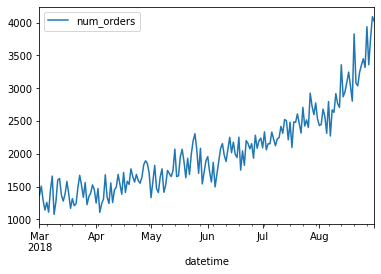

In [ ]:
df.resample('1D').sum().plot()

Ресемплирую по дням. На графике виден постоянный рост заказов в течение года

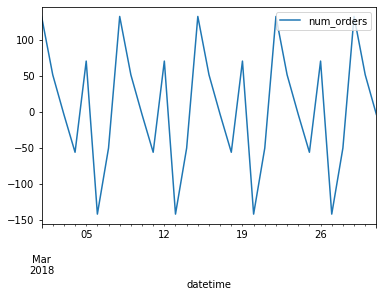

In [ ]:
seasonal_decompose(df['2018-03-01':'2018-03-31'].resample('1D').sum()).seasonal.plot()

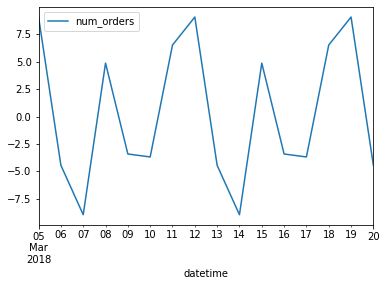

In [ ]:
seasonal_decompose(df['2018-03-05':'2018-03-20'].resample('1D').mean()).seasonal.plot()

Понедельник пятое число. На графике видно, что пики заказов в понедельник, четверг, воскресенье

## Обучение

In [ ]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [ ]:
df['month'] = df.index.month

In [ ]:
df['day'] = df.index.day

In [ ]:
df['dayofweek'] = df.index.dayofweek

In [ ]:
def make_features(data, max_lag, rolling_mean_size):
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data

In [ ]:
df = make_features(df,20,20)

In [ ]:
df.head()

,num_orders,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,3,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,1,3,66.0,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df.dropna(inplace = True)

Создаю фичи. Вытаскиваю месяц, день и создаю 10 лаг.

In [ ]:
train, test = train_test_split(df, shuffle = False, test_size = 0.1)

In [ ]:
train, valid = train_test_split(train, shuffle = False, test_size = 0.2)

In [ ]:
print(train.index.min(), train.index.max())
print(valid.index.min(),valid.index.max())
print(test.index.min(),test.index.max())

2018-03-01 20:00:00 2018-07-11 15:00:00
2018-07-11 16:00:00 2018-08-13 15:00:00
2018-08-13 16:00:00 2018-08-31 23:00:00


Разбиваю на выборки, проверяю, что последовательность верная

In [ ]:
df.columns

Index(['num_orders', 'month', 'day', 'dayofweek', 'lag_1', 'lag_2', 'lag_3',
       'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8', 'lag_9', 'lag_10',
       'lag_11', 'lag_12', 'lag_13', 'lag_14', 'lag_15', 'lag_16', 'lag_17',
       'lag_18', 'lag_19', 'lag_20', 'rolling_mean'],
      dtype='object')

In [ ]:
x_col = ['month', 'day', 'dayofweek', 'lag_1', 'lag_2', 'lag_3',
       'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8', 'lag_9', 'lag_10',
       'lag_11', 'lag_12', 'lag_13', 'lag_14', 'lag_15', 'lag_16', 'lag_17',
       'lag_18', 'lag_19', 'lag_20', 'rolling_mean']

In [ ]:
y_col = ['num_orders']

In [ ]:
model = CatBoostRegressor(random_state = 4, verbose = 200)

In [ ]:
model.fit(train[x_col], train[y_col])

Learning rate set to 0.047912
0:	learn: 33.7564227	total: 54.3ms	remaining: 54.3s
200:	learn: 18.9761181	total: 1.18s	remaining: 4.69s
400:	learn: 15.6940925	total: 2.21s	remaining: 3.31s
600:	learn: 13.2945484	total: 3.25s	remaining: 2.16s
800:	learn: 11.5139488	total: 4.29s	remaining: 1.06s
999:	learn: 10.0460083	total: 5.31s	remaining: 0us


In [ ]:
predictions = model.predict(valid[x_col])

In [ ]:
mse(valid[y_col], predictions)**0.5

35.25239004046843

In [ ]:
best_mse = 1000
for est in range(1,100,4):
    for depth in range(1,100,4):
        for leaf in range(1,100,4):
            model = RandomForestRegressor(random_state = 4, n_estimators = est, max_depth = depth
                                          , min_samples_leaf = leaf, n_jobs = -1)
            model.fit(train[x_col], train[y_col])
            MSE = mse(valid[y_col], model.predict(valid[x_col]))**0.5
            if MSE < best_mse:
                best_mse = MSE
                best_est = est
                best_depth = depth
                best_leaf = leaf
best_mse, best_est, best_depth, best_leaf

Выходные данные были обрезаны до нескольких последних строк (5000).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys
/usr

(37.37967303257373, 97, 37, 1)

In [ ]:
best_mse2 = 1000
for depth in range(1,20,1):
    for mw in range(1,20,1):
        model = XGBRegressor(random_state = 4, max_depth = depth, min_child_weight = mw)
        model.fit(train[x_col], train[y_col])
        MSE = mse(valid[y_col], model.predict(valid[x_col]))**0.5
        if MSE < best_mse2:
            best_mw = mw
            best_mse2 = MSE
            best_depth2 = depth
best_mse2, best_depth2, best_mw

[18:15:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:15:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:15:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:15:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:15:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:15:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:15:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:15:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

(35.776903221982195, 4, 10)

Лучший результат (35) показал кэтбуст, так что для тестирования беру его. Перебор в цикле для других моделей спрятал, т.к. очень долго перебирает. Значения рмсе были 38 и 37

## Тестирование

In [ ]:
train = train.append(valid)

In [ ]:
train.index.is_monotonic

True

Соединяю треин и валид выборки, проверяю, что правильно срослись

In [ ]:
model = CatBoostRegressor(random_state = 4, verbose = 200)

In [ ]:
model.fit(train[x_col], train[y_col])

Learning rate set to 0.049855
0:	learn: 38.0985581	total: 7.98ms	remaining: 7.98s
200:	learn: 21.6483408	total: 1.33s	remaining: 5.28s
400:	learn: 17.8738140	total: 2.55s	remaining: 3.81s
600:	learn: 15.2948356	total: 3.77s	remaining: 2.5s
800:	learn: 13.3500270	total: 4.96s	remaining: 1.23s
999:	learn: 11.8293249	total: 6.18s	remaining: 0us


In [ ]:
predictions = model.predict(test[x_col])

In [ ]:
mse(test[y_col], predictions)**0.5

46.70934005866972

In [ ]:
model = DummyRegressor(strategy = 'mean')

In [ ]:
model.fit(train[x_col], train[y_col])

DummyRegressor(constant=None, quantile=None, strategy='mean')

In [ ]:
predictions = model.predict(test[x_col])

In [ ]:
mse(test[y_col], predictions)**0.5

84.69056594015109

Кэтбуст выдал мсе 47, чего достаточно для выполнения задания, при этом среднее дает мсе 84.